In [0]:
import numpy as np
#from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
#from td_utils import *
%matplotlib inline

In [0]:
path = "/content/drive/My Drive/Artificial-Intelligence/Honeywell//"

In [0]:
Tx = 1000 # The number of time steps input to the model from the spectrogram
n_freq = 80 # Number of frequencies input to the model at each time step of the spectrogram

In [0]:
Ty = 1000 # The number of time steps in the output of our model

In [0]:
# Load preprocessed training examples
X = np.load(path + "X_data.npy")
Y = np.load(path + 'Y_data.npy')

mx = np.max(X,axis=0)
X = X/mx

shape_x = (1800,1000,80)
X1 = np.reshape(X,shape_x)
shape_y = (1800,1000,1)
Y1 = np.reshape(Y,shape_y)

In [0]:
np.save('max-model-norm.npy',mx)

In [0]:
print(X1.shape,Y1.shape)

(1800, 1000, 80) (1800, 1000, 1)


# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(160,1,strides=1)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    #X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(128,return_sequences = True)(X)                            # GRU (use 128 units and return the sequences)
    #X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(128,return_sequences=True)(X)                               # GRU (use 128 units and return the sequences)
#     X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
#     X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [0]:
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 80)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 160)         12960     
_________________________________________________________________
batch_normalization_9 (Batch (None, 1000, 160)         640       
_________________________________________________________________
activation_3 (Activation)    (None, 1000, 160)         0         
_________________________________________________________________
gru_7 (GRU)                  (None, 1000, 128)         110976    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1000, 128)         512       
_________________________________________________________________
gru_8 (GRU)                  (None, 1000, 128)         98688     
__________

**Expected Output**:

<table>
    <tr>
        <td>
            **Total params**
        </td>
        <td>
           522,561
        </td>
    </tr>
    <tr>
        <td>
            **Trainable params**
        </td>
        <td>
           521,657
        </td>
    </tr>
    <tr>
        <td>
            **Non-trainable params**
        </td>
        <td>
           904
        </td>
    </tr>
</table>

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 at spectrogram to 1375. 

## 2.2 - Fit the model

Trigger word detection takes a long time to train. To save time, we've already trained a model for about 3 hours on a GPU using the architecture you built above, and a large training set of about 4000 examples. Let's load the model. 

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [0]:
hist1 = model.fit(X1[:,:,:], Y1[:,:,:], batch_size = 32, epochs=5)

Epoch 1/5
1800/1800 [==============================] - 137s 76ms/step - loss: 0.3401 - acc: 0.8750
Epoch 2/5
1800/1800 [==============================] - 135s 75ms/step - loss: 0.2517 - acc: 0.9085
Epoch 3/5
1800/1800 [==============================] - 135s 75ms/step - loss: 0.2323 - acc: 0.9127
Epoch 4/5
1800/1800 [==============================] - 135s 75ms/step - loss: 0.2185 - acc: 0.9184
Epoch 5/5
1800/1800 [==============================] - 135s 75ms/step - loss: 0.2145 - acc: 0.9207


In [0]:
model.save('model-norm.h5')

In [0]:
path_x = 'Edu\Hackathons\Honeywell\TestData\edit.npy'
X_dev = np.load(path_x)
path_y = 'Edu\Hackathons\Honeywell\TestData\edit_labels.npy'
Y_dev = np.load(path_y)
X_dev1 = X_dev[:135000,:]
Y_dev1 = Y_dev[:135000,:]
X_dev1 = np.reshape(X_dev1,(135,1000,80))
Y_dev1 = np.reshape(Y_dev1,(135,1000,1))
print(X_dev1.shape,Y_dev1.shape)

(135, 1000, 80) (135, 1000, 1)


In [0]:
# Load preprocessed training examples
X = np.load(path + "X_data.npy")
Y = np.load(path + 'Y_data.npy')
shape_x = (1800,1000,80)
X1 = np.reshape(X,shape_x)
shape_y = (1800,1000,1)
Y1 = np.reshape(Y,shape_y)

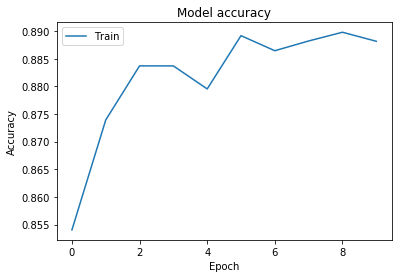

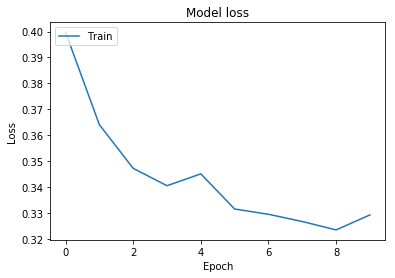

In [0]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(hist1.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist1.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [0]:
# Load preprocessed dev set examples
X_dev = np.load(path + "X\FS_P01_dev_022.npy")
Y_dev = np.load(path + 'Y\FS_P01_dev_022_labels.npy')

X_dev1 = np.reshape(X_dev[:180000,:],shape_x)
Y_dev1 = np.reshape(Y_dev[:180000,:],shape_y)
print(X_dev1.shape)
Y_dev1.shape

(180, 1000, 80)


(180, 1000, 1)

In [0]:
model0 = keras.models.load_model('Edu\Hackathons\Honeywell\model.h5')

In [0]:
loss, acc = model.evaluate(X1[0:1,:,:], Y1[0:1,:,:])
print("Dev set accuracy = ", acc)

1/1 [==============================] - 0s 318ms/step
Dev set accuracy =  0.8669999837875366


In [0]:
Y1.shape

(1800, 1000, 1)

In [0]:
y_pred = model.predict(X_dev1[:,:,:])
y_pred.shape

(135, 1000, 1)

array([[0.80149436, 0.9588386 , 0.98469377, ..., 0.37236267, 0.31554633,
        0.28495687],
       [0.2873343 , 0.17225912, 0.13853967, ..., 0.9994378 , 0.998911  ,
        0.99912405],
       [0.8765099 , 0.94664073, 0.9659317 , ..., 0.06416044, 0.06459859,
        0.05694959],
       ...,
       [0.24891904, 0.16527504, 0.10731554, ..., 0.04436988, 0.043836  ,
        0.0452995 ],
       [0.31063086, 0.19955441, 0.1367931 , ..., 0.69649583, 0.6338048 ,
        0.6074967 ],
       [0.35336393, 0.26908082, 0.22005925, ..., 0.07896721, 0.08160043,
        0.07800585]], dtype=float32)

In [0]:
y_pred = (y_pred>=0.5)*1
y_pred = y_pred.flatten()
Y_true = Y_dev1.flatten()

In [0]:
from sklearn.metrics import recall_score,precision_score,f1_score
print('Precision Score = ',precision_score(Y_true, y_pred))
print('Recall Score = ',recall_score(Y_true, y_pred))
print('F1 Score = ',f1_score(Y_true, y_pred))

Precision Score =  0.8505683818948471
Recall Score =  0.9926554267650158
F1 Score =  0.9161354320141208


In [0]:
Y1[0,680:690,:]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])